<a href="https://colab.research.google.com/github/Sanyam-Jain1/Lunar-DEM-generation/blob/main/lunar_dem_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import cv2

# replace 'filename.tif' with the actual filename after upload
image = cv2.imread('/content/drive/MyDrive/ch1_tmc_20081214_I00421_D00423_020940_seg1_NA_ortho.tif', cv2.IMREAD_UNCHANGED)

plt.imshow(image, cmap='gray')  # or remove cmap if it's a color image
plt.axis('off')
plt.show()


error: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:79: error: (-215:Assertion failed) pixels <= CV_IO_MAX_IMAGE_PIXELS in function 'validateInputImageSize'


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/drive/MyDrive/ch1_tmc_20081214_I00421_D00423_020940_seg1_NA_ortho.tif')

plt.imshow(img)
plt.axis('off')
plt.show()


DecompressionBombError: Image size (2145217800 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

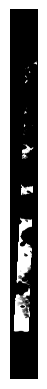

In [ ]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

img = Image.open('/content/drive/MyDrive/ch1_tmc_20081214_I00421_D00423_020940_seg1_NA_dem.tif')

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.show()


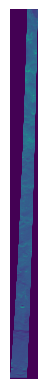

In [ ]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

img = Image.open('/content/drive/MyDrive/ch1_tmc_20081214_I00421_D00423_020940_seg1_NA_ortho.tif')

# downsample: e.g., 10x smaller
small = img.resize((img.width // 10, img.height // 10))

import matplotlib.pyplot as plt
plt.imshow(small)
plt.axis('off')
plt.show()


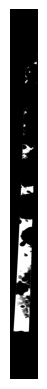

In [ ]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

img = Image.open('/content/drive/MyDrive/ch1_tmc_20081214_I00421_D00423_020940_seg1_NA_dem.tif')

# downsample: e.g., 10x smaller
small = img.resize((img.width // 10, img.height // 10))

import matplotlib.pyplot as plt
plt.imshow(small)
plt.axis('off')
plt.show()


✅ Image loaded: (10000, 4000)
✅ Noise reduction done
✅ Illumination correction done
✅ Contrast enhancement done


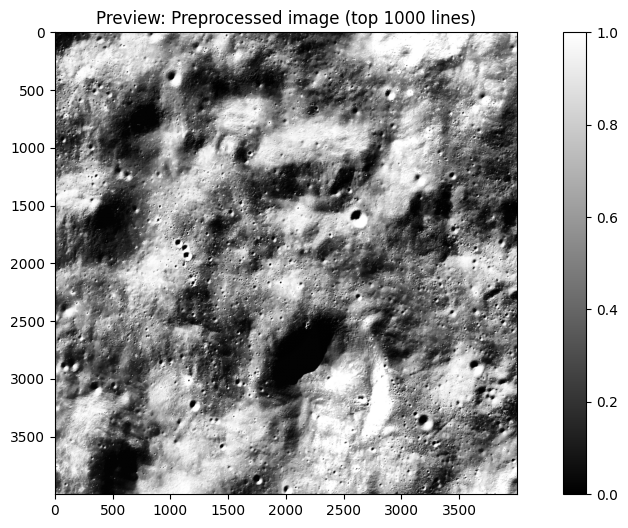

✅ Saved: /content/preprocessed_thumbnail.png


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# === Parameters from your XML metadata ===
img_shape = (205808, 4000)
sun_elevation = 10.6   # degrees
sun_azimuth = 163.9    # degrees
pixel_resolution = 10.57  # m/pixel

# === Step 1: Load TMC image from raw binary ===
img_file = '/content/drive/MyDrive/ch1_tmc_ncn_20090505T1513463425_d_img_d18.img'

# Read raw as unsigned 16-bit little-endian
N = 10000  # process only top 2000 lines (you can adjust)
with open(img_file, 'rb') as f:
    img = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))


print("✅ Image loaded:", img.shape)

# === Step 2: Noise reduction ===
# Convert to 8-bit
img_min, img_max = np.percentile(img, [2, 98])  # robust range
img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)

# fastNlMeansDenoising
denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)

# Back to float32 scaled
denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

print("✅ Noise reduction done")

# === Step 3: Illumination correction ===
# No per-pixel incidence raster → use average sun elevation
incidence_angle = 90 - sun_elevation   # ≈79.4°
incidence_rad = np.deg2rad(incidence_angle)
cos_i = np.cos(incidence_rad)

illum_corrected = denoised / cos_i
illum_corrected = np.clip(illum_corrected, 0, np.percentile(illum_corrected, 99))

print("✅ Illumination correction done")

# === Step 4: Contrast enhancement (CLAHE) ===
# Convert to 8-bit
ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced8 = clahe.apply(illum8)

enhanced = enhanced8.astype(np.float32) / 255.0

print("✅ Contrast enhancement done")

# === Step 5: Quick preview ===
# Image too large: take a small top slice
preview = enhanced[:4000, :]

plt.figure(figsize=(12,6))
plt.imshow(preview, cmap='gray')
plt.title('Preview: Preprocessed image (top 1000 lines)')
plt.colorbar()
plt.show()

# === Step 6: Save thumbnail for DEM or shape-from-shading later ===
# Scale full enhanced image to manageable size (e.g., 4000 x 200)
thumbnail = cv2.resize(enhanced, (4000, 200), interpolation=cv2.INTER_AREA)
plt.imsave('/content/preprocessed_thumbnail.png', thumbnail, cmap='gray')

print("✅ Saved: /content/preprocessed_thumbnail.png")


✅ Parsed metadata:
   Image shape: (162188, 4000)
   Sun elevation: 9.52683
   Sun azimuth: 213.54196
   Pixel resolution: 5.63 m/pixel
✅ Image loaded: (10000, 4000)
✅ Preprocessing done
✅ Saved: /content/output_dem.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


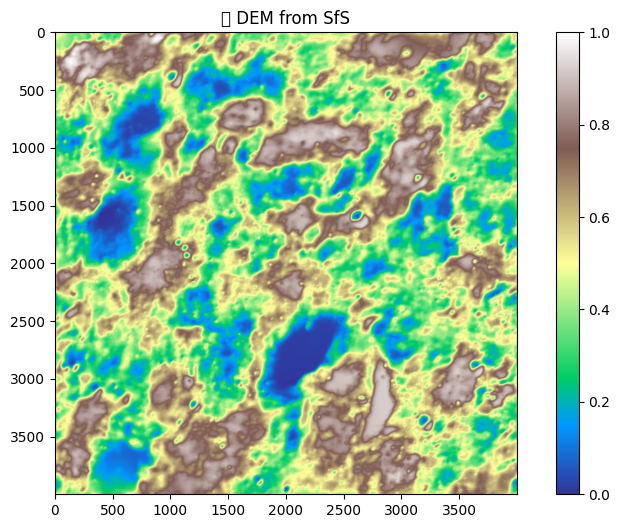

✅ Saved: /content/output_disparity.png


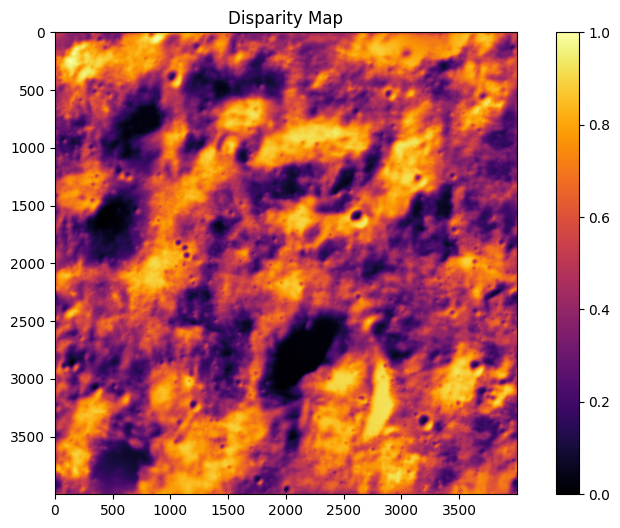

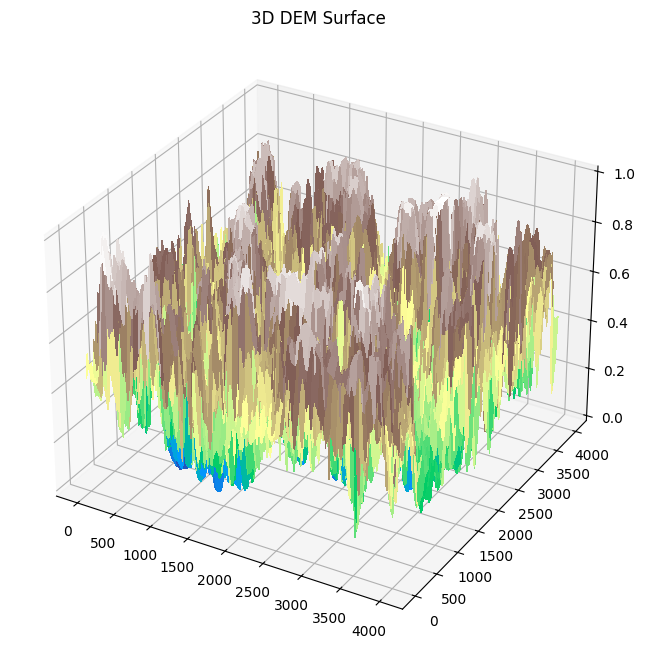

✅ Absolute DEM saved: /content/output_absolute_dem.tif


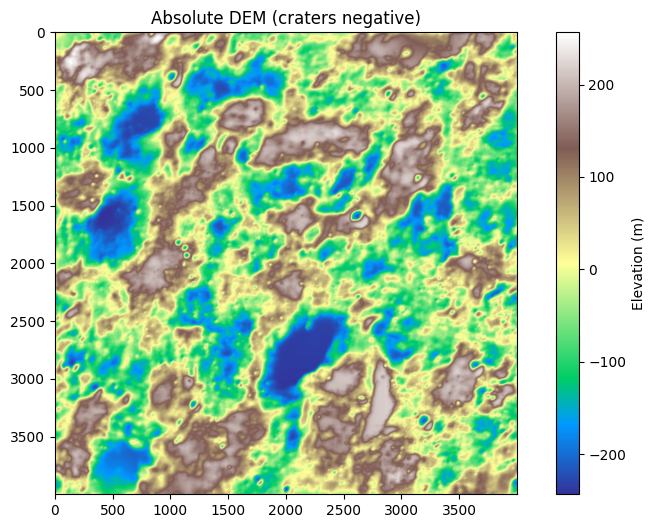

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft2, ifft2, fftfreq
from mpl_toolkits.mplot3d import Axes3D
import xml.etree.ElementTree as ET
from pathlib import Path

# -------------------- SfS Functions --------------------
def lambertian_shade(normals, light_dir, albedo=1.0):
    return albedo * np.clip(np.sum(normals * light_dir.reshape(1, 1, 3), axis=2), 0, 1)

def classical_sfs(I, light_dir, albedo=1.0, iters=300, lr=0.1, smooth_sigma=1.0):
    H, W = I.shape
    Z = np.zeros((H, W), dtype=np.float32)
    for _ in range(iters):
        p = np.gradient(Z, axis=1)
        q = np.gradient(Z, axis=0)
        Nx, Ny, Nz = -p, -q, np.ones_like(Z)
        norm = np.sqrt(Nx**2 + Ny**2 + Nz**2 + 1e-8)
        normals = np.dstack((Nx / norm, Ny / norm, Nz / norm))
        I_pred = lambertian_shade(normals, light_dir, albedo)
        diff = I - I_pred
        diff_smoothed = gaussian_filter(diff, sigma=smooth_sigma)
        Z += lr * diff_smoothed
        Z = gaussian_filter(Z, sigma=smooth_sigma)
    return Z

def frankot_chellappa(p, q):
    H, W = p.shape
    wx = fftfreq(W).reshape(1, -1)
    wy = fftfreq(H).reshape(-1, 1)
    WX, WY = np.meshgrid(wx, wy)
    denom = WX**2 + WY**2
    denom[denom == 0] = 1e-8
    p_fft, q_fft = fft2(p), fft2(q)
    Z_fft = (-1j * WX * p_fft - 1j * WY * q_fft) / denom
    return np.real(ifft2(Z_fft))

# -------------------- Metadata Parser --------------------
def parse_metadata(xml_path):
    ns = {
        'isda': 'https://isda.issdc.gov.in/pds4/isda/v1',
        'pds': 'http://pds.nasa.gov/pds4/pds/v1'
    }
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Find image shape
    axis_arrays = root.findall('.//pds:Axis_Array', ns)
    lines = int(axis_arrays[0].find('pds:elements', ns).text)
    samples = int(axis_arrays[1].find('pds:elements', ns).text)
    img_shape = (lines, samples)

    # Find sun elevation & azimuth
    sun_elevation = float(root.find('.//isda:sun_elevation', ns).text)
    sun_azimuth = float(root.find('.//isda:sun_azimuth', ns).text)

    # Pixel resolution
    pixel_resolution = float(root.find('.//isda:pixel_resolution', ns).text)

    print("✅ Parsed metadata:")
    print(f"   Image shape: {img_shape}")
    print(f"   Sun elevation: {sun_elevation}")
    print(f"   Sun azimuth: {sun_azimuth}")
    print(f"   Pixel resolution: {pixel_resolution} m/pixel")
    return img_shape, sun_elevation, sun_azimuth, pixel_resolution

# -------------------- Preprocessing --------------------
def preprocess_image(img, sun_elevation):
    img_min, img_max = np.percentile(img, [2, 98])
    img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)
    denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

    incidence_angle = 90 - sun_elevation
    cos_i = np.cos(np.deg2rad(incidence_angle))
    illum_corrected = np.clip(denoised / cos_i, 0, np.percentile(denoised / cos_i, 99))

    ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
    illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced8 = clahe.apply(illum8)
    enhanced = enhanced8.astype(np.float32) / 255.0
    return enhanced

# -------------------- Visualization --------------------
def save_and_plot(title, img, filename, cmap='terrain', scale_to_255=True):
    if scale_to_255:
        img_to_save = (img / (np.max(img) + 1e-8) * 255).astype(np.uint8)
    else:
        img_to_save = img
    cv2.imwrite(filename, img_to_save)
    print(f"✅ Saved: {filename}")
    plt.figure(figsize=(10,6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.show()

def plot_3d_surface(Z, title='3D DEM Surface'):
    X, Y = np.meshgrid(np.arange(Z.shape[1]), np.arange(Z.shape[0]))
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='terrain', linewidth=0, antialiased=False)
    ax.set_title(title)
    plt.show()

# -------------------- Main Pipeline --------------------
def main():
    # === Paths ===
    xml_file = '/content/drive/MyDrive/ch1_tmc_ncn_20090505T1513463425_d_img_d18.xml'
    img_file = '/content/drive/MyDrive/ch1_tmc_ncn_20090505T1513463425_d_img_d18.img'

    # === Parse metadata ===
    img_shape, sun_elevation, sun_azimuth, pixel_resolution = parse_metadata(xml_file)

    N = 10000  # rows to load for speed

    # === Load partial image ===
    with open(img_file, 'rb') as f:
        img = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))
    print("✅ Image loaded:", img.shape)

    # === Preprocess ===
    enhanced = preprocess_image(img, sun_elevation)
    print("✅ Preprocessing done")

    # === SfS DEM generation ===
    az_rad, el_rad = np.deg2rad(sun_azimuth), np.deg2rad(sun_elevation)
    light_vector = np.array([
        np.cos(el_rad) * np.cos(az_rad),
        np.cos(el_rad) * np.sin(az_rad),
        np.sin(el_rad)
    ])

    small_block = enhanced[0:4000, :]
    classical_dem = classical_sfs(small_block, light_vector)
    p, q = np.gradient(classical_dem, axis=1), np.gradient(classical_dem, axis=0)
    refined_dem = frankot_chellappa(p, q)
    refined_dem -= np.min(refined_dem)
    refined_dem /= (np.max(refined_dem) + 1e-8)

    # === Save & plot DEM ===
    save_and_plot('🌙 DEM from SfS', refined_dem, '/content/output_dem.png')

    # === Disparity map ===
    disparity = refined_dem - np.min(refined_dem)
    save_and_plot('Disparity Map', disparity, '/content/output_disparity.png', cmap='inferno')

    # === 3D plot ===
    plot_3d_surface(refined_dem)

# Center around 0 so we have negatives for craters
    refined_dem -= np.mean(refined_dem)

    # Scale to meters: choose factor based on your data
    absolute_dem = refined_dem * 500  # adjust: bigger number = deeper craters

    # Convert to signed 16-bit integer for saving
    abs_dem_img = absolute_dem.astype(np.int16)

    # Save
    cv2.imwrite('/content/output_absolute_dem.tif', abs_dem_img)
    print("✅ Absolute DEM saved: /content/output_absolute_dem.tif")

    # Plot
    plt.figure(figsize=(10,6))
    plt.imshow(absolute_dem, cmap='terrain')
    plt.title('Absolute DEM (craters negative)')
    plt.colorbar(label='Elevation (m)')
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 41.3 MB/s eta 0:00:00


✅ File opened: /content/drive/MyDrive/ch1_tmc_ndn_20090505T1513463425_d_dtm_d18.tif
Size: 76274 x 4307
CRS: PROJCS["Polar StereoGraphic",GEOGCS["Polar StereoGraphic",DATUM["Moon Spheroid",SPHEROID["Moon Spheroid",1737400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",90],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]
Bands: 1


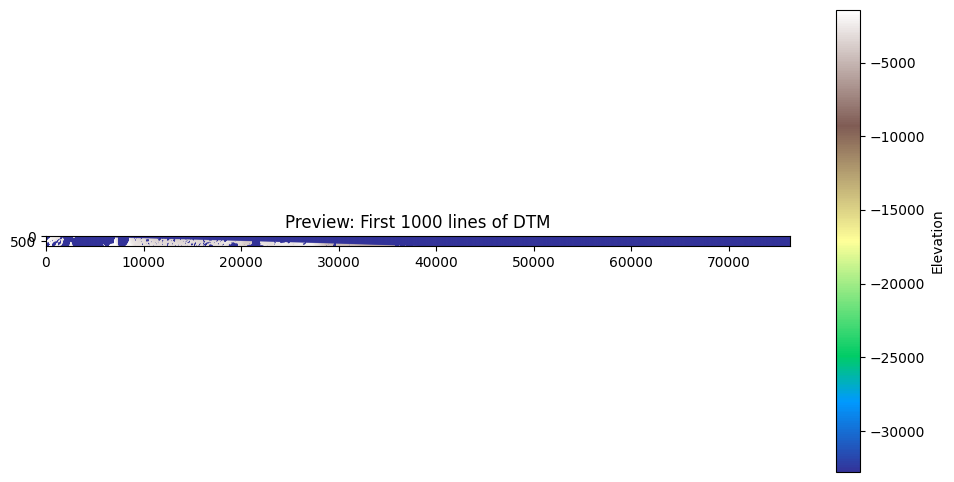

In [ ]:
import rasterio
import matplotlib.pyplot as plt

dtm_path = "/content/drive/MyDrive/ch1_tmc_ndn_20090505T1513463425_d_dtm_d18.tif"   # change to your actual path

with rasterio.open(dtm_path) as src:
    print(f"✅ File opened: {dtm_path}")
    print(f"Size: {src.width} x {src.height}")
    print(f"CRS: {src.crs}")
    print(f"Bands: {src.count}")

    # Read smaller: first 1000 rows only
    preview = src.read(1, window=((0,1000), (0, src.width)))

plt.figure(figsize=(12,6))
plt.imshow(preview, cmap='terrain')
plt.title("Preview: First 1000 lines of DTM")
plt.colorbar(label='Elevation')
plt.show()


✅ Image preview loaded: (4000, 4000)


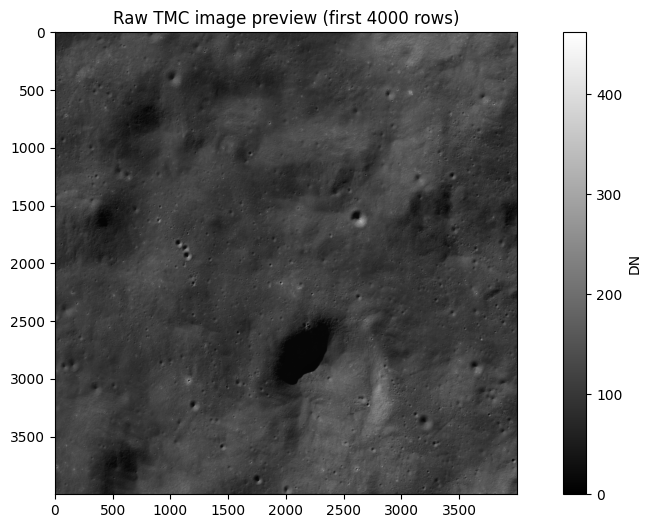

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Parameters from your XML ===
img_shape = (205808, 4000)          # total image shape (lines, samples)
img_file = '/content/drive/MyDrive/ch1_tmc_ncn_20090505T1513463425_d_img_d18.img'

# === Step 1: Read only the first N rows to preview safely ===
N = 4000  # you can increase to 4000 if Colab doesn't crash

with open(img_file, 'rb') as f:
    img_preview = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))

print("✅ Image preview loaded:", img_preview.shape)

# === Step 2: Display ===
plt.figure(figsize=(12,6))
plt.imshow(img_preview, cmap='gray')   # change to 'terrain' if you'd like
plt.title(f"Raw TMC image preview (first {N} rows)")
plt.colorbar(label='DN')
plt.show()


✅ Original official DTM shape: (4307, 76274)
✅ Resized DTM shape: (205808, 4000)
✅ Official DTM first 4000 lines shape: (4000, 4000)
✅ Computed DEM shape: (4000, 4000)


/tmp/ipython-input-7-1357836801.py:54: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


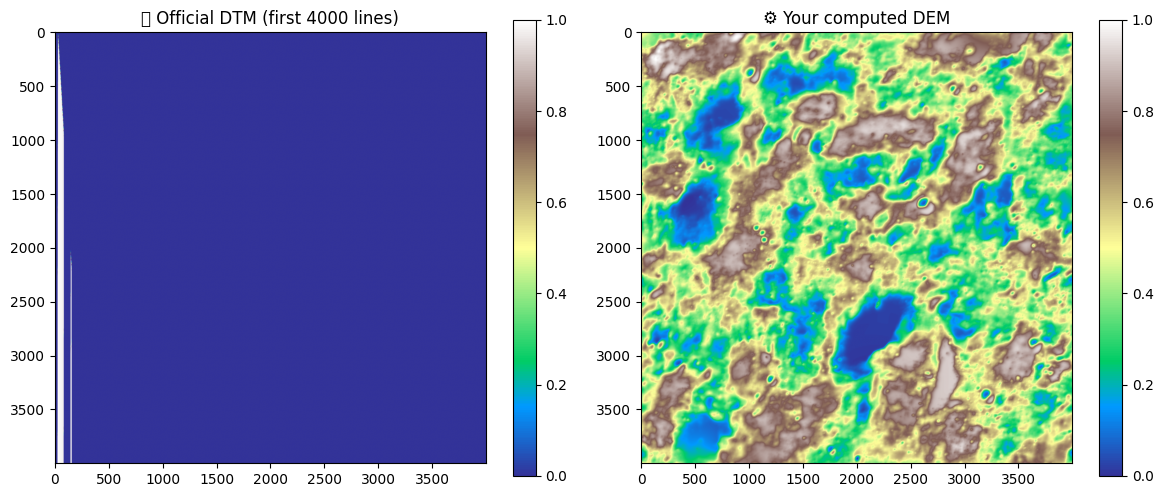

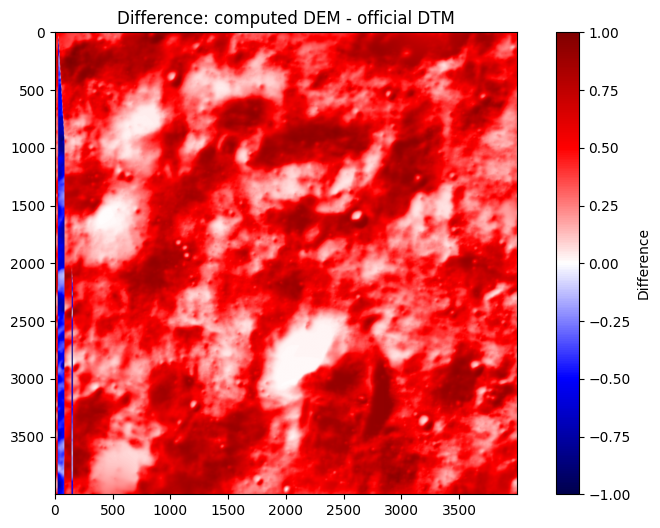

✅ All done: resized, aligned, compared!


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Paths & shapes ===
dtm_file = '/content/drive/MyDrive/ch1_tmc_ndn_20090505T1513463425_d_dtm_d18.tif'
raw_image_shape = (205808, 4000)  # from your XML
computed_block_lines = 4000       # you computed DEM for first 4000 lines

# === Step 1: Load official DTM ===
official_dtm = cv2.imread(dtm_file, cv2.IMREAD_UNCHANGED).astype(np.float32)
print("✅ Original official DTM shape:", official_dtm.shape)

# === Step 2: Resize to raw image full shape ===
resized_dtm = cv2.resize(
    official_dtm,
    (raw_image_shape[1], raw_image_shape[0]),   # (width, height)
    interpolation=cv2.INTER_LINEAR
)
print("✅ Resized DTM shape:", resized_dtm.shape)

# === Step 3: Extract first 4000 lines ===
official_first_4000 = resized_dtm[:computed_block_lines, :]
print("✅ Official DTM first 4000 lines shape:", official_first_4000.shape)

# === Step 4: Load your computed DEM for comparison ===
# Replace this with loading your DEM e.g. from file:
# === Step 4: Load your computed DEM for comparison ===
computed_dem = cv2.imread('/content/output_dem.png', cv2.IMREAD_UNCHANGED).astype(np.float32)

# Optional normalization
computed_dem -= np.min(computed_dem)
computed_dem /= (np.max(computed_dem) + 1e-8)

print("✅ Computed DEM shape:", computed_dem.shape)
# For demo, I'll create dummy DEM with same shape:
# computed_dem = np.random.rand(computed_block_lines, raw_image_shape[1]).astype(np.float32)
# computed_dem /= np.max(computed_dem)  # normalize to 0–1

# === Step 5: Normalize official DTM block to 0–1 ===
official_norm = (official_first_4000 - np.min(official_first_4000)) / (np.max(official_first_4000)-np.min(official_first_4000))

# === Step 6: Plot both DEMs ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(official_norm, cmap='terrain')
plt.title('📦 Official DTM (first 4000 lines)')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(computed_dem, cmap='terrain')
plt.title('⚙️ Your computed DEM')
plt.colorbar()
plt.tight_layout()
plt.show()

# === Step 7: Compute and plot difference map ===
diff = computed_dem - official_norm

plt.figure(figsize=(10,6))
plt.imshow(diff, cmap='seismic', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.title('Difference: computed DEM - official DTM')
plt.colorbar(label='Difference')
plt.show()

print("✅ All done: resized, aligned, compared!")
